In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/test2classes.zip" "test2classes.zip"
#!cp "/content/drive/My Drive/Histopathology data/DenseNet2categoriesmodel.pth" "DenseNet2categoriesmodel.pth"

In [ ]:
!unzip -q test2classes.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5# 
batch_size_test = 10 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets

test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: TUM


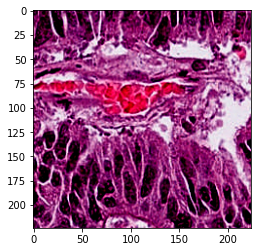

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # down sampling done by batch norm-> conv1x1-> avg pool
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)


class Bottlenecklayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        
        inner_channel = 4 * growth_rate

        # For bottleneck layer batch norm->relu->1x1 conv->batch norm->relu->1x1 conv
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)



class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=2):
        super().__init__()
        self.growth_rate = growth_rate

        
        inner_channels = 2 * growth_rate

        
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            out_channels = int(reduction * inner_channels)
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottlenecklayer, [6,12,24,16], growth_rate=32)

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = densenet121()
model.load_state_dict(torch.load('DenseNet2SGD.pth', map_location=device))
model=model.to(device)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
   
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function 
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
import os.path
from os import path



stl,acct,y,y_pred,prob=test(model, device, test_loader)

print('average accuracy: ',acct)

Test: Average loss: 0.0332, Accuracy: 7122/7200 (98.92%)

average accuracy:  98.91666666666667


In [ ]:
flat_prob=[element for sublist in prob for element in sublist]
proba=np.array(flat_prob)
flatten_y = [element for sublist in y for element in sublist]
flatten_y_pred = [element for sublist in y_pred for element in sublist]
flatten_y_pred = [element for sublist in flatten_y_pred for element in sublist]

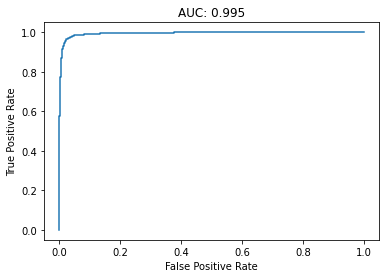

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = proba[::,1]
fpr, tpr, thresholds = roc_curve(flatten_y, y_pred_proba)
auc = roc_auc_score(flatten_y, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC: %.3f' % auc)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision=precision_score(flatten_y, flatten_y_pred)
precision=precision*100
print(precision)

98.16739606126916


In [ ]:
recall=recall_score(flatten_y, flatten_y_pred)
recall=recall*100
print(recall)

99.69444444444444


In [ ]:
f1=f1_score(flatten_y, flatten_y_pred)
f1=f1*100
print(f1)

98.92502756339582
